In [10]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas
import regionmask
from eofs.xarray import Eof
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import glob
import seaborn as sns
sns.set_style("white")

In [11]:
def get_region(X,region):

    abbrevs= X.region.abbrevs
    I=np.nonzero(np.in1d(abbrevs,region))[0]
    data=X.sel(region=X.region.values[I])
    #data["region"]=region
    return data
def standardize(X):
    pi=X.sel(time=slice(1850,1899))
    mu=pi.mean(dim="time")
    sigma=pi.std(dim="time")
    return (X-mu)/sigma


# Reading in the drought atlas data
GEDA from Cook et al 2024

In [12]:
fname_geda = "../DATA/geda_trim.nc"
geda=xr.open_dataset(fname_geda)
geda=geda.scPDSI
#Ocean mask = 9.e36
geda=geda.where(geda<1.e20)
geda=geda.rename({"yr":"time"})

# AR6 regions
Average GEDA over AR6 land regions and eliminate regions where coverage is verysparse (GIC, NEAF, SAH)

In [13]:
geda_regions=np.array(['NEU', 'WCE', 'EEU', 'MED', 'RAR', 'WSB',
       'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA'])

In [14]:
mask=regionmask.defined_regions.ar6.land.mask_3D(geda)
weights = np.cos(np.deg2rad(geda.lat))
drought_regional = geda.weighted(mask * weights).mean(dim=("lat", "lon"))
drought_regional=drought_regional.dropna(dim="region")
#drought_regional=get_region(drought_regional,geda_regions)

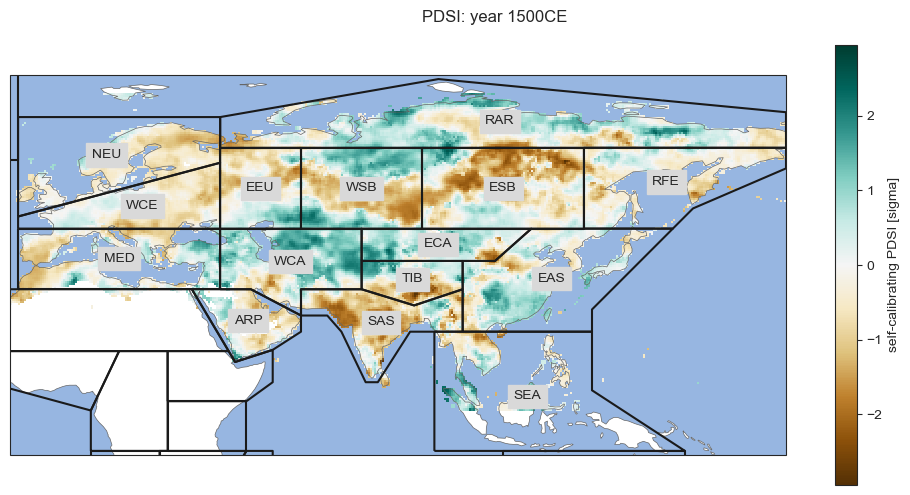

In [421]:
fig=plt.figure(figsize=(10,5))
ax=regionmask.defined_regions.ar6.land.plot(label="abbrev")
kids=ax.get_children()
kid=kids[20]
for kid in kids:
    if type(kid) == mpl.text.Text:
        if not (kid.get_text() in coords["region"]):
            kid.set_visible(False)
geda.sel(time=1500).plot(cmap=cm.BrBG)
ax.add_feature(cfeature.OCEAN)
ax.set_ylim(-11,83)
ax.set_xlim(-12,180)
tmp=fig.suptitle("PDSI: year 1500CE")
plt.tight_layout()
plt.savefig("../Writeup/FIGS/GEDA.png")

In [15]:
# standardize and scale
def prep_drought_atlas_data(regions=geda_regions,pi_period=(1000,1849),recent_period=(1900,2020)):
    data=get_region(drought_regional,regions)
    preindustrial=data.sel(time=slice(pi_period[0],pi_period[1]))
    #standardize using preindustrial mean and sigma
    mu=preindustrial.mean(dim="time")
    sigma=preindustrial.std(dim="time")
    preindustrial_scaled=(preindustrial-mu)/sigma
    
    #standardize using mu and sigma from preindustrial
    recent=data.sel(time=slice(recent_period[0],recent_period[1]))
    recent_scaled=(recent-mu)/sigma
    preindustrial_scaled["region"]=regions
    recent_scaled["region"]=regions
    return preindustrial_scaled,recent_scaled
        

In [196]:
def match_region_abbrev_to_number(regionabbrev):
    return regionmask.defined_regions.ar6.all.abbrevs.index(regionabbrev)
    


In [ ]:
# Prepare the drought atlas data and define the coordinates
preindustrial,recent= prep_drought_atlas_data([ 'NEU', 'WCE', 'EEU', 'MED',  'RAR', 'WSB',
       'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA'],recent_period=(1850,2020))

In [ ]:
hadunc=xr.open_dataset("../DATA/OBS/HadCRUT.5.0.2.0.analysis.ensemble_series.global.annual.nc")
hadcrut_ensemble=hadunc.sel(time=slice("1850-1-1","2020-12-31")).tas
hadcrut_ensemble["time"]=recent.time
baseline=hadcrut_ensemble.sel(time=slice(1850,1900)).mean(dim="time")
hadcrut_ensemble=hadcrut_ensemble-baseline

hadcrut_ensemble=hadcrut_ensemble.expand_dims({"dataset":["HadCRUT"]})

In [19]:
# Read in Berkeley Earth
#uncertainties are the 95% confidence interval = 2 sigma
#I HATE PANDAS, there has to be an easier way to do this
bearth=pd.read_csv("https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Land_and_Ocean_summary.txt",\
                  comment="%",header=0,sep="     ",engine="python")
first=[1850, -0.450,0.158,np.nan,np.nan,  -0.430 , 0.145,np.nan,np.nan]

titles=["Year", "Annual Anomaly", "Annual Unc.", "Five-year Anomaly", "Five-year Unc.",\
        "Annual Anomaly (below sea ice)", "Annual Unc. (below sea ice)", \
        "Five-year Anomaly (below sea ice)", "Five-year Unc. (below sea ice)"]

D={}
for i in range(len(titles)):
   
    D[titles[i]]=np.append(first[i],bearth[bearth.columns[i]].values)

bearth_data=pd.DataFrame(D)
d = {
    "coords": {
        "time": {"dims": "time", "data": D["Year"], "attrs": {"units": "years"}}
    },
    "attrs": {"title": "air temperature"},
    "dims": "time",
    "data_vars": {
        "tas": {"dims": "time", "data": D["Annual Anomaly"]},
        "unc": {"dims": "time", "data": D["Annual Unc."]},
    },
}
berkeleyearth = xr.Dataset.from_dict(d)
# create an artificial ensemble
mu_be=berkeleyearth.tas.values
sigma_be=berkeleyearth.unc.values/2.
berkeley_earth_ensemble=np.zeros((200,len(mu_be)))
for i in range(len(mu_be)):
    berkeley_earth_ensemble[:,i]=np.random.normal(mu_be[i],sigma_be[i],200)
berkeley_earth_ensemble=xr.DataArray(data=berkeley_earth_ensemble[np.newaxis,:,:],dims=("dataset","realization","time"),\
coords={"dataset":["Berkeley Earth"],"realization":hadcrut_ensemble.realization,"time":berkeleyearth.time})


In [20]:
# read in GISTEMP
gistemp_data=pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv",header=1)
gistemp_data["J-D"]
gistemp=xr.DataArray(data=gistemp_data["J-D"].values[:-1].astype(np.float32),\
                     dims=("time"),\
                     coords={"time":gistemp_data["Year"].values[:-1]}).rename("tas")

# giss uncertainty: this is two sigma
gissunc=pd.read_csv("https://data.giss.nasa.gov/gistemp/uncertainty/v1.2.1/totalCI_ERA.csv")
sigma_gis=gissunc["ci95"].values/2.
# pad with last value to extend it to 2023
nextra=len(gistemp.time)-len(sigma_gis)
sigma_gis=np.append(sigma_gis,np.tile(sigma_gis[-1],nextra))
mu_gis=gistemp.values
gistemp_ensemble=np.zeros((200,len(mu_gis)))
for i in range(len(mu_gis)):
    gistemp_ensemble[:,i]=np.random.normal(mu_gis[i],sigma_gis[i],200)
gistemp_ensemble=xr.DataArray(data=gistemp_ensemble[np.newaxis,:,:],dims=("dataset","realization","time"),\
coords={"dataset":["GISTEMP"],"realization":hadcrut_ensemble.realization,"time":gistemp.time})


/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, 

Text(0.5, 1.0, 'Global Temperature Relative to 1850-1900 average')

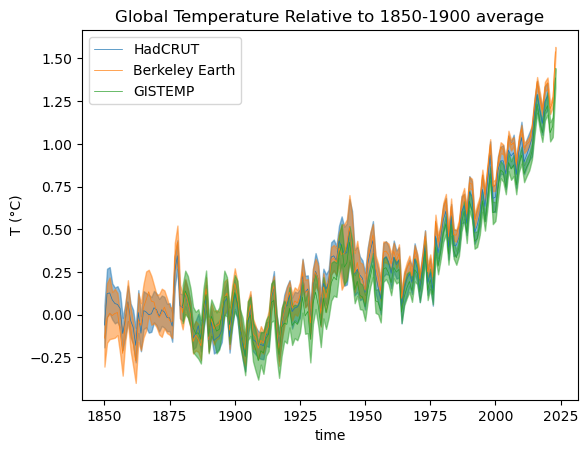

In [30]:
#Make a merged dataset of all temperature anomalies and their uncertainties
T_anomalies=xr.concat([hadcrut_ensemble,berkeley_earth_ensemble,gistemp_ensemble],dim="dataset")
T_anomalies=T_anomalies -T_anomalies.sel(time=slice(1850,1900)).mean(dim="time")
tmp=[T_anomalies.mean(dim="realization").isel(dataset=i).plot(lw=.5,label=T_anomalies.dataset.values[i]) for i in range(3)]
tmp=[az.plot_hdi(T_anomalies.time.values,T_anomalies.isel(dataset=i),smooth=False,color=cm.tab10(i),hdi_prob=.95) for i in range(3)]
T_anomalies=T_anomalies.sel(time=slice(1850,2020))
plt.legend()
plt.ylabel("T (°C)")
plt.title("Global Temperature Relative to 1850-1900 average")

# Meta-Analysis: Random Effects Model
Every ensemble member $y_k$ of dataset $k$ (where $k$ = [HadCrut, Berkeley Earth, GISTEMP]) is assumed to be drawn from a normal distribution where the standard deviation varies with time.
$$y_k \sim MN(\theta_k,\rm{diag}(\sigma^2_1 \ldots \sigma^2_t))$$
The dataset means $\theta_k$ are all assumed to be distributed around the ``true" mean T:
$$\theta_k \sim N(T,\tau^2)$$
This is a random effects model because we allow the parameter $\tau$ to be nonzero.  We place priors on $\mu$ and $\tau$:
$$ \mu \sim N(0,1)$$
$$\tau \sim HalfNormal(1)$$

In [32]:
lags=2
coords={
    "lags": reversed(range(-lags, 0)),
    "region": tuple(preindustrial.region.abbrevs.values),
    "cross_region":tuple(preindustrial.region.abbrevs.values),
    "time_pi": preindustrial.time[lags:],
    "time_recent":recent.time[lags:]
}
with pm.Model(coords=coords) as T_random_effects_model:
    T=pm.Normal("T",0,1,dims=("time_recent"))
    tau=pm.HalfNormal("tau",1)
    Tobserved={}
    theta={}
    for dataset in ["HadCRUT","Berkeley Earth","GISTEMP"]:
        data=T_anomalies.sel(dataset=dataset).values[:,lags:]
        theta[dataset]=pm.Normal("theta_"+dataset,T,tau,dims=("time_recent"))
        std=np.std(data,axis=0)
        if dataset == "GISTEMP":
            #Pad the standard deviation: missing data here
            std=np.where(~np.isnan(std),std,1)
        Tobserved[dataset]=pm.Normal("obs_"+dataset,theta[dataset],sigma=std,observed=data)
    
    trace_reff=pm.sample()       

/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in obs_GISTEMP contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T, tau, theta_HadCRUT, theta_Berkeley Earth, theta_GISTEMP, obs_GISTEMP_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, 

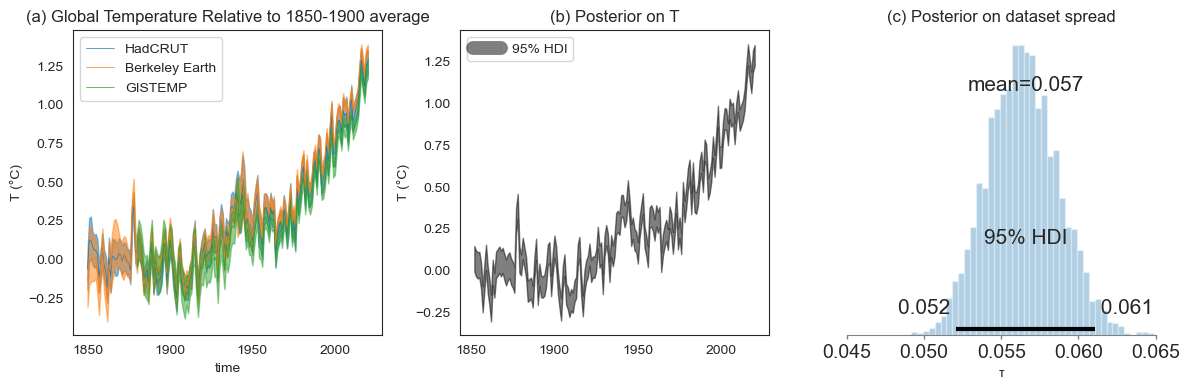

In [340]:
plt.figure(figsize=(12,4))
ax1=plt.subplot(131)
tmp=[T_anomalies.mean(dim="realization").isel(dataset=i).plot(lw=.5,label=T_anomalies.dataset.values[i]) for i in range(3)]
tmp=[az.plot_hdi(T_anomalies.time.values,T_anomalies.isel(dataset=i),smooth=False,color=cm.tab10(i),hdi_prob=.95) for i in range(3)]
T_anomalies=T_anomalies.sel(time=slice(1850,2020))
plt.legend()
plt.ylabel("T (°C)")
plt.title("(a) Global Temperature Relative to 1850-1900 average")

ax2=plt.subplot(132)
x=T_anomalies.time[lags:]

#az.plot_hdi(x,T_anomalies.sel(dataset="HadCRUT").values[:,lags:],smooth=False,color=cm.tab10(0))
#az.plot_hdi(x,T_anomalies.sel(dataset="Berkeley Earth").values[:,lags:],smooth=False,color=cm.tab10(2))
#az.plot_hdi(x,T_anomalies.sel(dataset="GISTEMP").values[:,lags:],smooth=False,color=cm.tab10(3))
az.plot_hdi(x,trace_reff.posterior.T,smooth=False,color="k",hdi_prob=.95,ax=ax2)
tmp,=plt.plot(x,trace_reff.posterior.T.mean(dim=("chain","draw")),"k",lw=10,alpha=.5,label="95% HDI")
plt.legend()
tmp.set_visible(False)
plt.title("(b) Posterior on T")
#az.plot_hdi(x,trace_fixed.posterior.theta_Berkeley Earth,smooth=False,color="k")
plt.ylabel("T (°C)")
ax3=plt.subplot(133)
az.plot_posterior(trace_reff.posterior.tau,ax=ax3,hdi_prob=.95,kind="hist",bins=50)
ax3.set_xlim(0.045,0.065)
tmp=plt.title("(c) Posterior on dataset spread")
tmp=plt.xlabel("τ")
tmp=plt.xticks(np.arange(0.045,0.065,.005))
plt.tight_layout()
plt.savefig("../Writeup/FIGS/RandomEffectsT.png")

In [ ]:
recent.shape

In [521]:
#preindustrial,recent=prep_data(["WCE","EEU","MED","NEU"])
lags = 2

coords={
    "lags": reversed(range(-lags, 0)),
    "region": tuple(preindustrial.region.abbrevs.values),
    "cross_region":tuple(preindustrial.region.abbrevs.values),
    "time_pi": preindustrial.time[lags:],
    "time_recent":recent.time[lags:]
}

with pm.Model(coords=coords) as global_T_model:
    #Learn the uncertain T
    T=pm.Normal("T",0,1,dims=("time_recent"))
    tau=pm.HalfNormal("τ",1)
    Tobserved={}
    theta={}
    for dataset in ["HadCRUT","Berkeley Earth","GISTEMP"]:
        data=T_anomalies.sel(dataset=dataset).values[:,lags:]
        theta[dataset]=pm.Normal("θ_"+dataset,T,tau,dims=("time_recent"))
        std=np.std(data,axis=0)
        if dataset == "GISTEMP":
            #Pad the standard deviation: missing data here
            std=np.where(~np.isnan(std),std,1)
        Tobserved[dataset]=pm.Normal(dataset,theta[dataset],sigma=std,observed=data)

    
    # Priors for the intercept, lagged coefficient, and noise terms
    intercept = 0 # during the pre-industrial period
    lag_coefs = pm.Normal("ℓ", mu=0, sigma=1, dims=("lags", "region"))
    # prior on fingerprint of regional PDSI response
    fingerprint=pm.Normal("β",mu=0,sigma=1,dims=("region"))
    
   

    # Compute autoregressive expectation for each region in preindustrial and recent.
    #Assume same lag coefs for both

    ar_pi={}
    ar_recent={}
    
    for regn in coords["region"]:
        j=coords["region"].index(regn)
        ar_pi[regn] = pm.math.sum([lag_coefs[i, j] * preindustrial.values[lags-(i+1): -(i+1),j]
            for i in range(lags)
        ], axis=0)  

        ar_recent[regn] = pm.math.sum([lag_coefs[i, j] * recent.values[lags-(i+1): -(i+1),j]
            for i in range(lags)
        ], axis=0)  
        
        

    # Stack autoregressive terms and add intercepts
    
    mean_pi = intercept + pm.math.stack([ar_pi[regn] for regn in coords["region"]], axis=-1)

  
    forced_response = pm.Deterministic("forced_response",\
                                       pm.math.stack([T*fingerprint[i] for i in range(len(coords["region"]))],\
                                                     axis=-1),dims=("time_recent", "region"))

    mean_recent = forced_response + pm.math.stack([ar_recent[regn] for regn in coords["region"]], axis=-1)

   
   
     #now take into account spatial covariance
    sigmaDist = pm.Exponential.dist(1.0)
    chol,_,_ = pm.LKJCholeskyCov('L', eta=4, n=len(coords["region"]),\
                                           sd_dist=sigmaDist,compute_corr=True)
    #chol = pm.expand_packed_triangular(len(coords["region"]), packed_chol, lower=True)
    cov = pm.Deterministic('Σ', chol.dot(chol.T),dims=("region","cross_region"))
    obs = pm.MvNormal("obs_pi", mu=mean_pi, chol=chol, observed=preindustrial[lags:], dims=("time_pi", "region"))
    obs_recent = pm.MvNormal("obs_recent",mu=mean_recent,chol=chol,observed=recent[lags:],dims=("time_recent","region"))
    #global_T_trace=pm.sample()

/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in GISTEMP contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


# Lag properties by region

In [256]:
def plot_GEDA(X,cmap=cm.BrBG,**kwargs):
    
    lon=np.arange(-11, 180)
    #lat=np.arange(-20,90)
    lat = np.arange(-10, 80)
    #lon=geda.lon
    #lat=geda.lat
    
    lon_edges=lon
    lat_edges=lat
    
    # for the plotting
    #lon_edges = np.arange(-180, 181)
    #lat_edges = np.arange(-90, 91)
    mask = regionmask.defined_regions.ar6.land.mask(lon, lat).values
    
    mask_ma = np.ma.masked_invalid(mask)
    my_mask=np.zeros_like(mask_ma)
    the_lag=-2
    
    for region in X.region:
        regnum=match_region_abbrev_to_number(region)
        my_mask[mask_ma==regnum]=float(X.sel(region=region))
    
    proj = ccrs.PlateCarree()
    ax = plt.subplot(111, projection=proj)
    
    #mask_ma = np.ma.masked_invalid(mask)
    
    
    my_mask=np.ma.masked_where(my_mask==0,my_mask)
    h = ax.pcolormesh(lon_edges, lat_edges, my_mask, transform=ccrs.PlateCarree(), cmap=cmap,**kwargs)
    cbar=plt.colorbar(h)
    
    ax.coastlines()
    return ax,cbar


In [282]:
import cartopy.feature as cfeature
import matplotlib as mpl

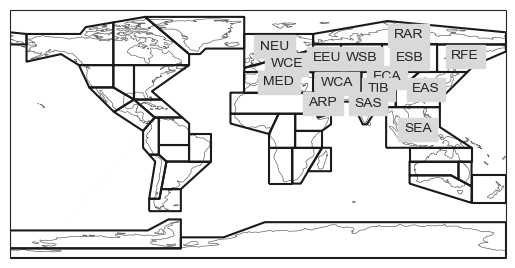

In [302]:
axes=regionmask.defined_regions.ar6.land.plot(label="abbrev")
kids=axes.get_children()
kid=kids[20]
for kid in kids:
    if type(kid) == mpl.text.Text:
        if not (kid.get_text() in coords["region"]):
            kid.set_visible(False)

In [393]:
def pretty_plot_GEDA(X,**kwargs):
    plt.figure(figsize=(10,5))
    axes=regionmask.defined_regions.ar6.land.plot(label="abbrev")
    kids=axes.get_children()
    kid=kids[20]
    for kid in kids:
        if type(kid) == mpl.text.Text:
            if not (kid.get_text() in coords["region"]):
                kid.set_visible(False)
    ax,cbar=plot_GEDA(X,**kwargs)
    #ax=plt.gca()
    ax.add_feature(cfeature.OCEAN)
    ax.set_ylim(-11,83)
    ax.set_xlim(-12,180)
    return ax,cbar

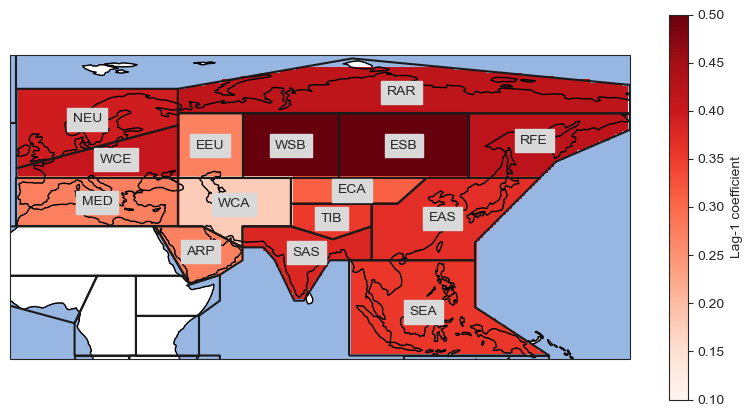

In [313]:
# Lag-1 coefficients
plt.figure(figsize=(10,5))
axes=regionmask.defined_regions.ar6.land.plot(label="abbrev")
kids=axes.get_children()
kid=kids[20]
for kid in kids:
    if type(kid) == mpl.text.Text:
        if not (kid.get_text() in coords["region"]):
            kid.set_visible(False)
ax,cbar=plot_GEDA(global_T_trace.posterior.lag_coefs.sel(lags=-1).mean(dim=("chain","draw")),cmap=cm.Reds,vmin=.1,vmax=.5)
#ax=plt.gca()
ax.add_feature(cfeature.OCEAN)
ax.set_ylim(-11,83)
ax.set_xlim(-12,180)
cbar.set_label("Lag-1 coefficient")
plt.savefig("../Writeup/FIGS/Lag1Coefficient.png")

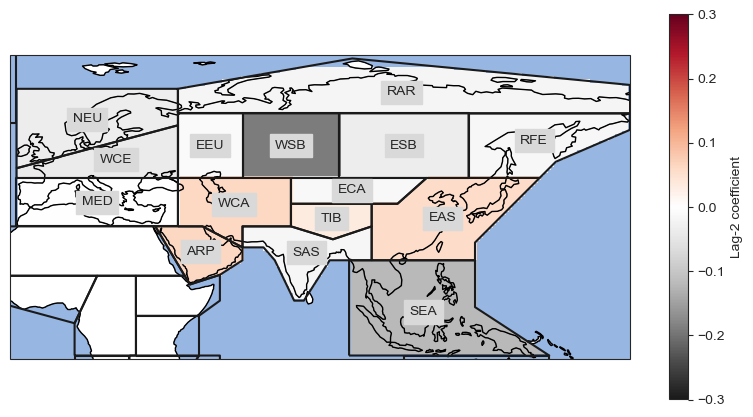

In [312]:
# Lag-2 coefficients
plt.figure(figsize=(10,5))
axes=regionmask.defined_regions.ar6.land.plot(label="abbrev")
kids=axes.get_children()
kid=kids[20]
for kid in kids:
    if type(kid) == mpl.text.Text:
        if not (kid.get_text() in coords["region"]):
            kid.set_visible(False)
ax,cbar=plot_GEDA(global_T_trace.posterior.lag_coefs.sel(lags=-2).mean(dim=("chain","draw")),cmap=cm.RdGy_r,vmin=-.3,vmax=.3)
#ax=plt.gca()
ax.add_feature(cfeature.OCEAN)
ax.set_ylim(-11,83)
ax.set_xlim(-12,180)
cbar.set_label("Lag-1 coefficient")

cbar.set_label("Lag-2 coefficient")
plt.savefig("../Writeup/FIGS/Lag2Coefficient.png")

# Covariance Matrix
Plotting the covariance matrix and comparing it to EOFs

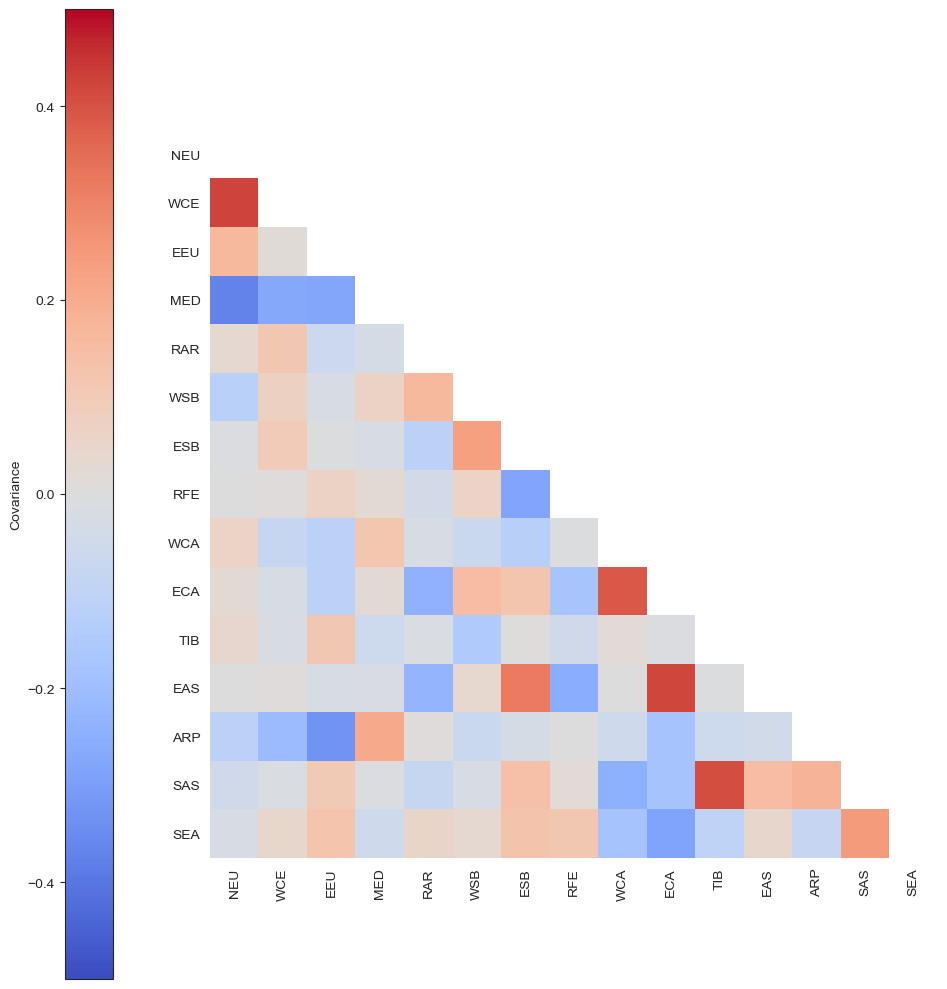

In [381]:
# Represent the correlation matrix
plt.figure(figsize=(10,10))
mycov=global_T_trace.posterior.cov.mean(dim=("chain","draw")).values
corr_mat = np.tril(mycov, k=-1)
corr_mat = np.ma.masked_where(corr_mat==0,corr_mat)
plt.imshow(corr_mat,cmap=cm.coolwarm,vmin=-.5,vmax=.5)
plt.colorbar(label="Covariance",location="left")
tmp=plt.xticks(np.arange(15),coords["region"],rotation=90)
tmp=plt.yticks(np.arange(15),coords["region"],rotation=0)
plt.gca().set_frame_on(False)
plt.tight_layout()
plt.savefig("../Writeup/FIGS/Covariance.png")

In [377]:
# Make the histograms pretty
postmeans=neu_cov_posteriors.mean(dim="samples")
#mn=np.min(postmeans)
#mx=np.max(postmeans)
mn=-0.4
mx=0.4
postmeans_scaled=(postmeans-mn)/(mx-mn)


array([1.54918731, 1.0316507 , 0.70078547, 0.03720303, 0.53738263,
       0.34886403, 0.48931359, 0.49573726, 0.57758006, 0.53075721,
       0.55100537, 0.49608988, 0.3608477 , 0.43955114, 0.46881655])

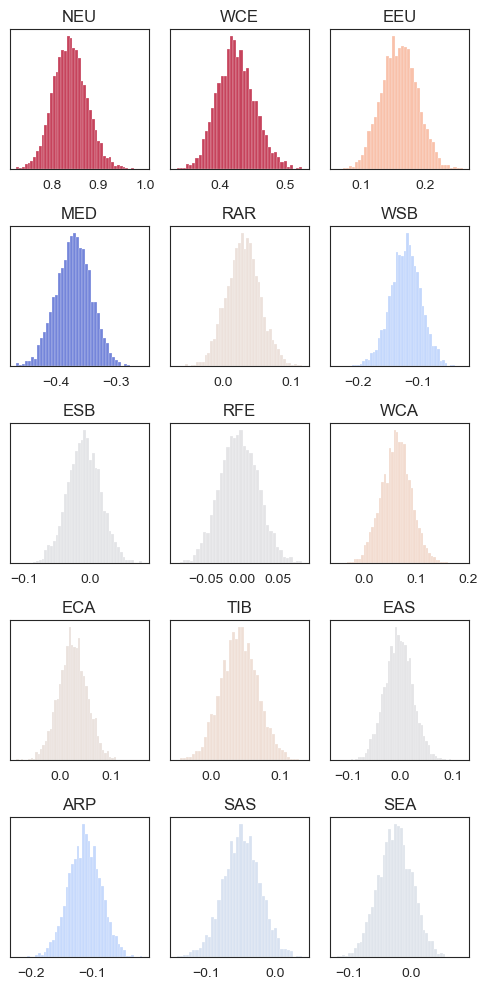

In [384]:
plt.figure(figsize=(5,10))
neu_cov_posteriors=global_T_trace.posterior.cov.sel(region="NEU").stack(samples=("chain","draw"))
i=1


nreg=len(coords["region"])
for reg in coords["region"]:
    plt.subplot(5,3,i)
    sns.histplot(neu_cov_posteriors.sel(cross_region=reg),color=cm.coolwarm(postmeans_scaled.values[i-1]))
    plt.title(reg)
    plt.ylabel("")
    plt.yticks([])
    

    i+=1
plt.tight_layout()
plt.savefig("../Writeup/FIGS/Covariance_Uncertainty.png")

# Visualizing the covariance matrix

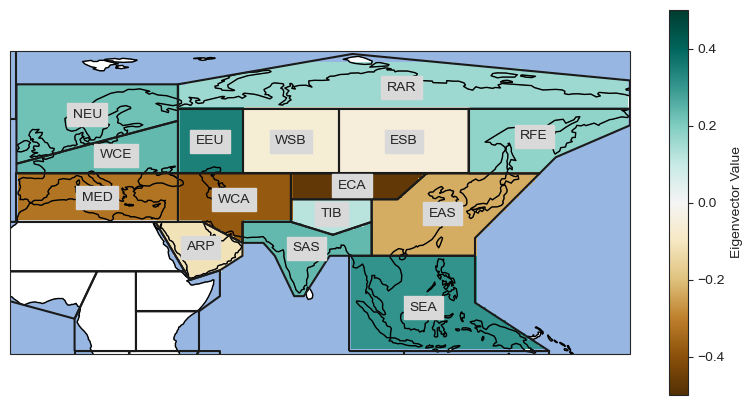

In [400]:
from numpy import linalg as LA
eigenvalues,eigenvectors=LA.eig(mycov)
eof1=eigenvectors[:,0]
ax,cbar=pretty_plot_GEDA(xr.DataArray(data=-eof1,dims=["region"],coords={"region":np.array(coords["region"])}),cmap=cm.BrBG,\
                vmin=-.5,vmax=.5)
cbar.set_label("Eigenvector Value")
plt.savefig("../Writeup/FIGS/Leading_Eigenvector.png")

# Comparision with EOF1
It resembles the leading EOF in many places, but note that the leading EOF neither incorporates uncertainty nor takes into account the autoregressive noise.

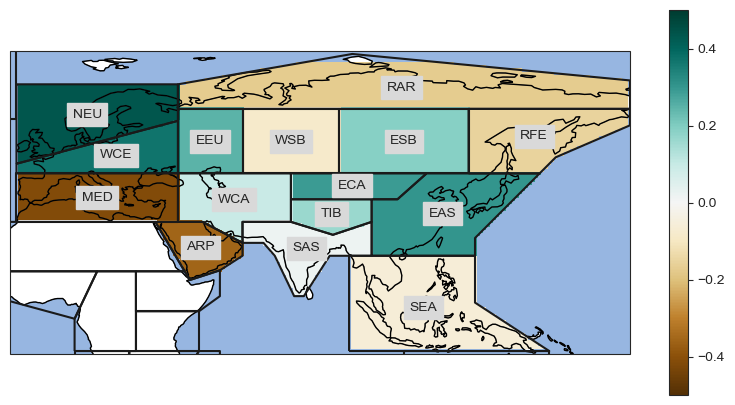

In [399]:
solver=Eof(preindustrial)
pretty_plot_GEDA(solver.eofs().sel(mode=0),cmap=cm.BrBG,\
                vmin=-.5,vmax=.5)
cbar.set_label("EOF loading")
plt.savefig("../Writeup/FIGS/EOF1.png")

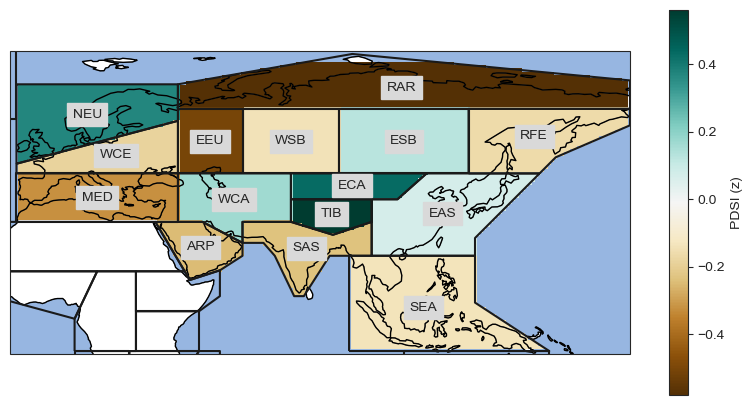

In [405]:
# Fingerprinting
ax,cbar=pretty_plot_GEDA(global_T_trace.posterior.fingerprint.mean(dim=("chain","draw")))
cbar.set_label("PDSI (z)")
plt.savefig("../Writeup/FIGS/Fingerprint.png")

# Attribution with autoregressive noise
Clearly, attribution is complicated by the presence of autoregressive noise.  External forcing leads to a change in the observed variable, which makes a change of the same sign more likely at the next time step.  Do we attribute this to the external forcing, or to the inherent memory of the system?  Need to do some model comparison here.  We construct a "counterfactual" where there is no forcing and recent variability is assumed to be a continuation of preindustrial variability.

In [526]:
#Hypothetical world where there is no forcing.
preindustrial,recent= prep_drought_atlas_data([ 'NEU', 'WCE', 'EEU', 'MED',  'RAR', 'WSB',
       'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA'],recent_period=(1850,2020))



#preindustrial,recent=prep_data(["WCE","EEU","MED","NEU"])
lags = 2

coords={
    "lags": reversed(range(-lags, 0)),
    "region": tuple(preindustrial.region.abbrevs.values),
    "cross_region":tuple(preindustrial.region.abbrevs.values),
    "time_pi": preindustrial.time[lags:],
    "time_recent":recent.time[lags:]
}

with pm.Model(coords=coords) as noforcing_model:
    # The first B bit:
    # Priors for the intercept, lagged coefficient, and noise terms
    #intercept = pm.Normal("intercept", mu=0, sigma=1, dims=("region",))
    intercept = 0
    lag_coefs = pm.Normal("ℓ", mu=0, sigma=1, dims=("lags", "region"))
    
    #T=T_nonstandard[lags:]
    #beta = pm.Normal("beta",mu=0,sigma=1,dims=("time_recent"))
    

    # Compute autoregressive expectation for each region

    ar_pi={}
    ar_recent={}
    
    for regn in coords["region"]:
        j=coords["region"].index(regn)
        ar_pi[regn] = pm.math.sum([lag_coefs[i, j] * preindustrial.values[lags-(i+1): -(i+1),j]
            for i in range(lags)
        ], axis=0)  

        ar_recent[regn] = pm.math.sum([lag_coefs[i, j] * recent.values[lags-(i+1): -(i+1),j]
            for i in range(lags)
        ], axis=0)  
        
        

    # Stack autoregressive terms and add intercepts
    
    mean_pi = intercept + pm.math.stack([ar_pi[regn] for regn in coords["region"]], axis=-1)

  
    

    mean_recent =  pm.math.stack([ar_recent[regn] for regn in coords["region"]], axis=-1)

   
    # The second B bit:
    # For modelling simplicity, we ignore the first observations, where we could
    # not observe the effects of all the lagged coefficients
    
     #now take into account spatial covariance
    sigmaDist = pm.Exponential.dist(1.0)
    chol,_,_ = pm.LKJCholeskyCov('L', eta=4, n=len(coords["region"]),\
                                           sd_dist=sigmaDist,compute_corr=True)
    #chol = pm.expand_packed_triangular(len(coords["region"]), packed_chol, lower=True)
    cov = pm.Deterministic('Σ', chol.dot(chol.T),dims=("region","cross_region"))
    obs = pm.MvNormal("obs_pi", mu=mean_pi, chol=chol, observed=preindustrial[lags:], dims=("time_pi", "region"))
    obs_recent = pm.MvNormal("obs_recent",mu=mean_recent,chol=chol,observed=recent[lags:],dims=("time_recent","region"))
   # noforcing_trace=pm.sample()

In [76]:
class Attributor():
    def __init__(self,PPD=None):
        if PPD is None:
            self.PPD={}
        else:
            self.PPD=PPD
    def add_PPD(self,model,trace,label):
        thinned_data=trace#.sel(draw=slice(None, None, 20))
        self.PPD[label] = pm.sample_posterior_predictive(thinned_data,model=model,var_names=["obs_recent"])
        
    def plot_diff(self,label1,label2,**kwargs):
        diff=self.PPD[label2].posterior_predictive.obs_recent -\
        self.PPD[label1].posterior_predictive.obs_recent
        diff.mean(dim=("chain","draw")).T.plot(cmap=cm.BrBG)
    def time_diff(self,label1,label2,timerange,region=None,**kwargs):
        diff=self.PPD[label2].posterior_predictive.obs_recent -\
        self.PPD[label1].posterior_predictive.obs_recent
        diff_time=diff.sel(time_recent = slice(timerange[0],timerange[1])).mean(dim="time_recent")
        if region is not None:
            az.plot_posterior(diff_time.sel(region=region),ref_val=0,hdi_prob=.66,**kwargs)
        else:
            az.plot_posterior(diff_time,ref_val=0,hdi_prob=.66,**kwargs)
    
        
        

In [77]:
ATT = Attributor()
ATT.add_PPD(global_T_model,global_T_trace,"global_T")
ATT.add_PPD(noforcing_model,noforcing_trace,"no forcing")

Sampling: [obs_recent]


Sampling: [obs_recent]


In [380]:
# How do we parameterize the expected forced response?  How about assuming it just depends on the global mean temperature?

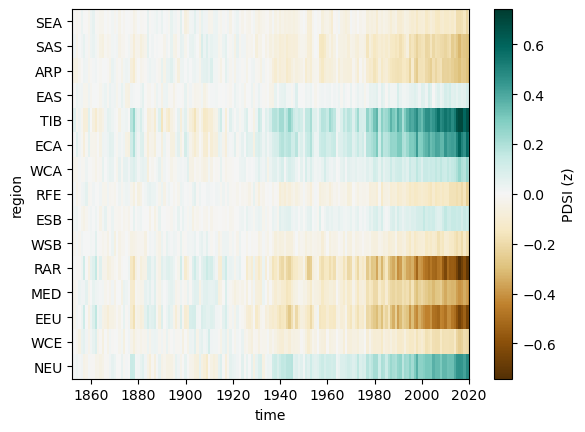

In [78]:
label1="no forcing"
label2 = "global_T"
diff=ATT.PPD[label2].posterior_predictive.obs_recent -\
        ATT.PPD[label1].posterior_predictive.obs_recent
diff=diff.rename("PDSI (z)")
diff.mean(dim=("chain","draw")).T.plot(cmap=cm.BrBG)
ax=plt.gca()
ax.set_xlabel("time")
ax.set_ylim(-.5,14.5)
plt.savefig("../Writeup/FIGS/GlobalTHovmueller.png")

In [181]:
posteriormean=twentyfirst.mean(dim="samples")
M=np.max(posteriormean)-np.min(posteriormean)
themin=np.min(posteriormean)
colors={}

for reg in posteriormean.region.values:
    i=float(posteriormean.sel(region=reg).values)
    colors[reg]=cm.BrBG((i-themin)/M)
 

In [423]:
# Try: separate distributions for forcing model and AR model
#Show observed quantities
recent.sel(time=slice(2000,2020)).mean(dim="time")

<xarray.DataArray 'scPDSI' (region: 15)> Size: 120B
array([ 0.71305373, -0.53432239, -0.4893765 , -0.73891648, -0.64135697,
       -0.0200924 ,  0.09914007,  0.34469153, -0.30917478,  0.41526006,
        1.082944  , -0.2779499 , -0.9576716 , -0.41780459,  0.34282633])
Coordinates:
    abbrevs  (region) <U4 240B 'NEU' 'WCE' 'EEU' 'MED' ... 'ARP' 'SAS' 'SEA'
    names    (region) <U19 1kB 'N.Europe' 'West&Central-Europe' ... 'S.E.Asia'
  * region   (region) <U3 180B 'NEU' 'WCE' 'EEU' 'MED' ... 'ARP' 'SAS' 'SEA'

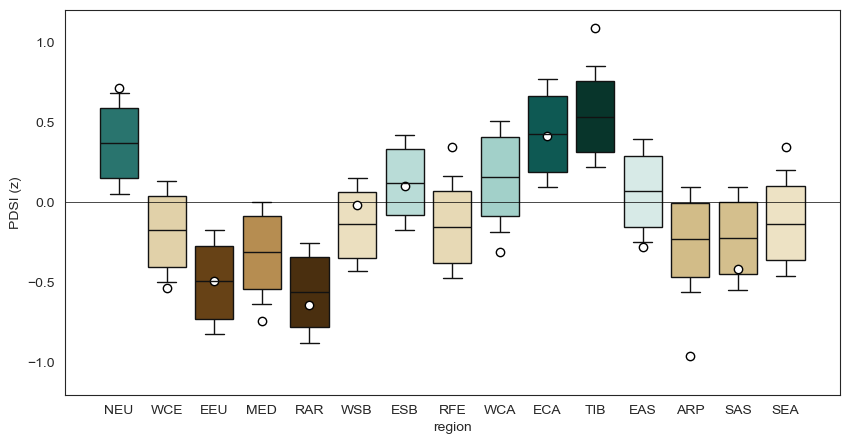

In [507]:
plt.figure(figsize=(10,5))
twentyfirst=diff.sel(time_recent=slice(2000,2020)).mean(dim="time_recent").stack(samples=("chain","draw"))
#sns.boxplot(twentyfirst.T,fliersize=0,whis=(17,83))
sns.boxplot(twentyfirst.T.to_pandas(),palette=colors,fliersize=0,whis=(17,83))
plt.axhline(0,c="k",lw=.5)
plt.ylabel("PDSI (z)")
plt.plot(recent.sel(time=slice(2000,2020)).mean(dim="time").values,"o",color="white",markeredgecolor="k")
#plt.savefig("../Writeup/FIGS/violinplot.png")
#tmp=plt.xticks(np.arange(15),coords["region"],rotation=90)
plt.ylim(-1.2,1.2)
plt.savefig("../Writeup/FIGS/Attributed.png")

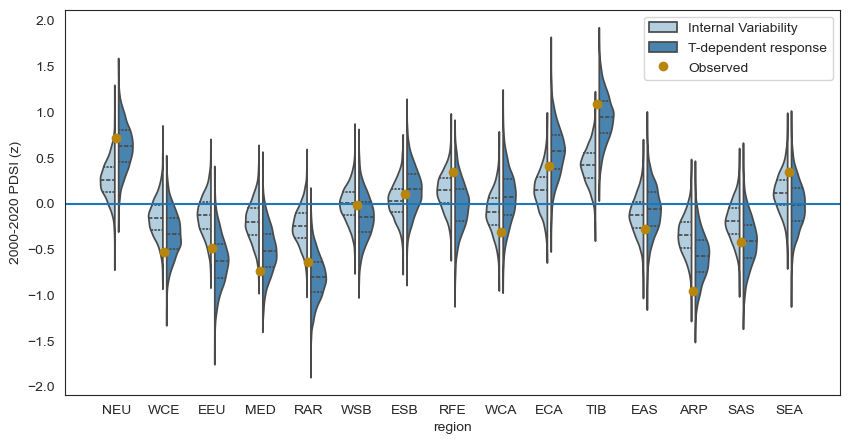

In [497]:
fig=plt.figure(figsize=(10,5))
withforcing=ATT.PPD["global_T"].\
posterior_predictive.obs_recent.stack(samples=("chain","draw")).sel(time_recent=slice(2000,2020)).mean(dim="time_recent")

noforcing=ATT.PPD["no forcing"].\
posterior_predictive.obs_recent.stack(samples=("chain","draw")).sel(time_recent=slice(2000,2020)).mean(dim="time_recent")


#withforcing.expand_dims(coords={"model":"T-dependent response"})
withforcing["model"]="T-dependent response"
#noforcing.expand_dims(coords={"model":"Internal Variability"})
noforcing["model"]="Internal Variability"
both=xr.concat([noforcing,withforcing],dim="model")
sns.violinplot(both.to_dataframe(),x="region", y="obs_recent",hue="model",split=True,inner="quart",palette="Blues",\
              gap=.2)
plt.axhline(0)
plt.plot(recent.sel(time=slice(2000,2020)).mean(dim="time").values,"o",color="darkgoldenrod",label="Observed")
plt.legend()
plt.ylabel("2000-2020 PDSI (z)")
plt.savefig("../Writeup/FIGS/SplitViolin.png")

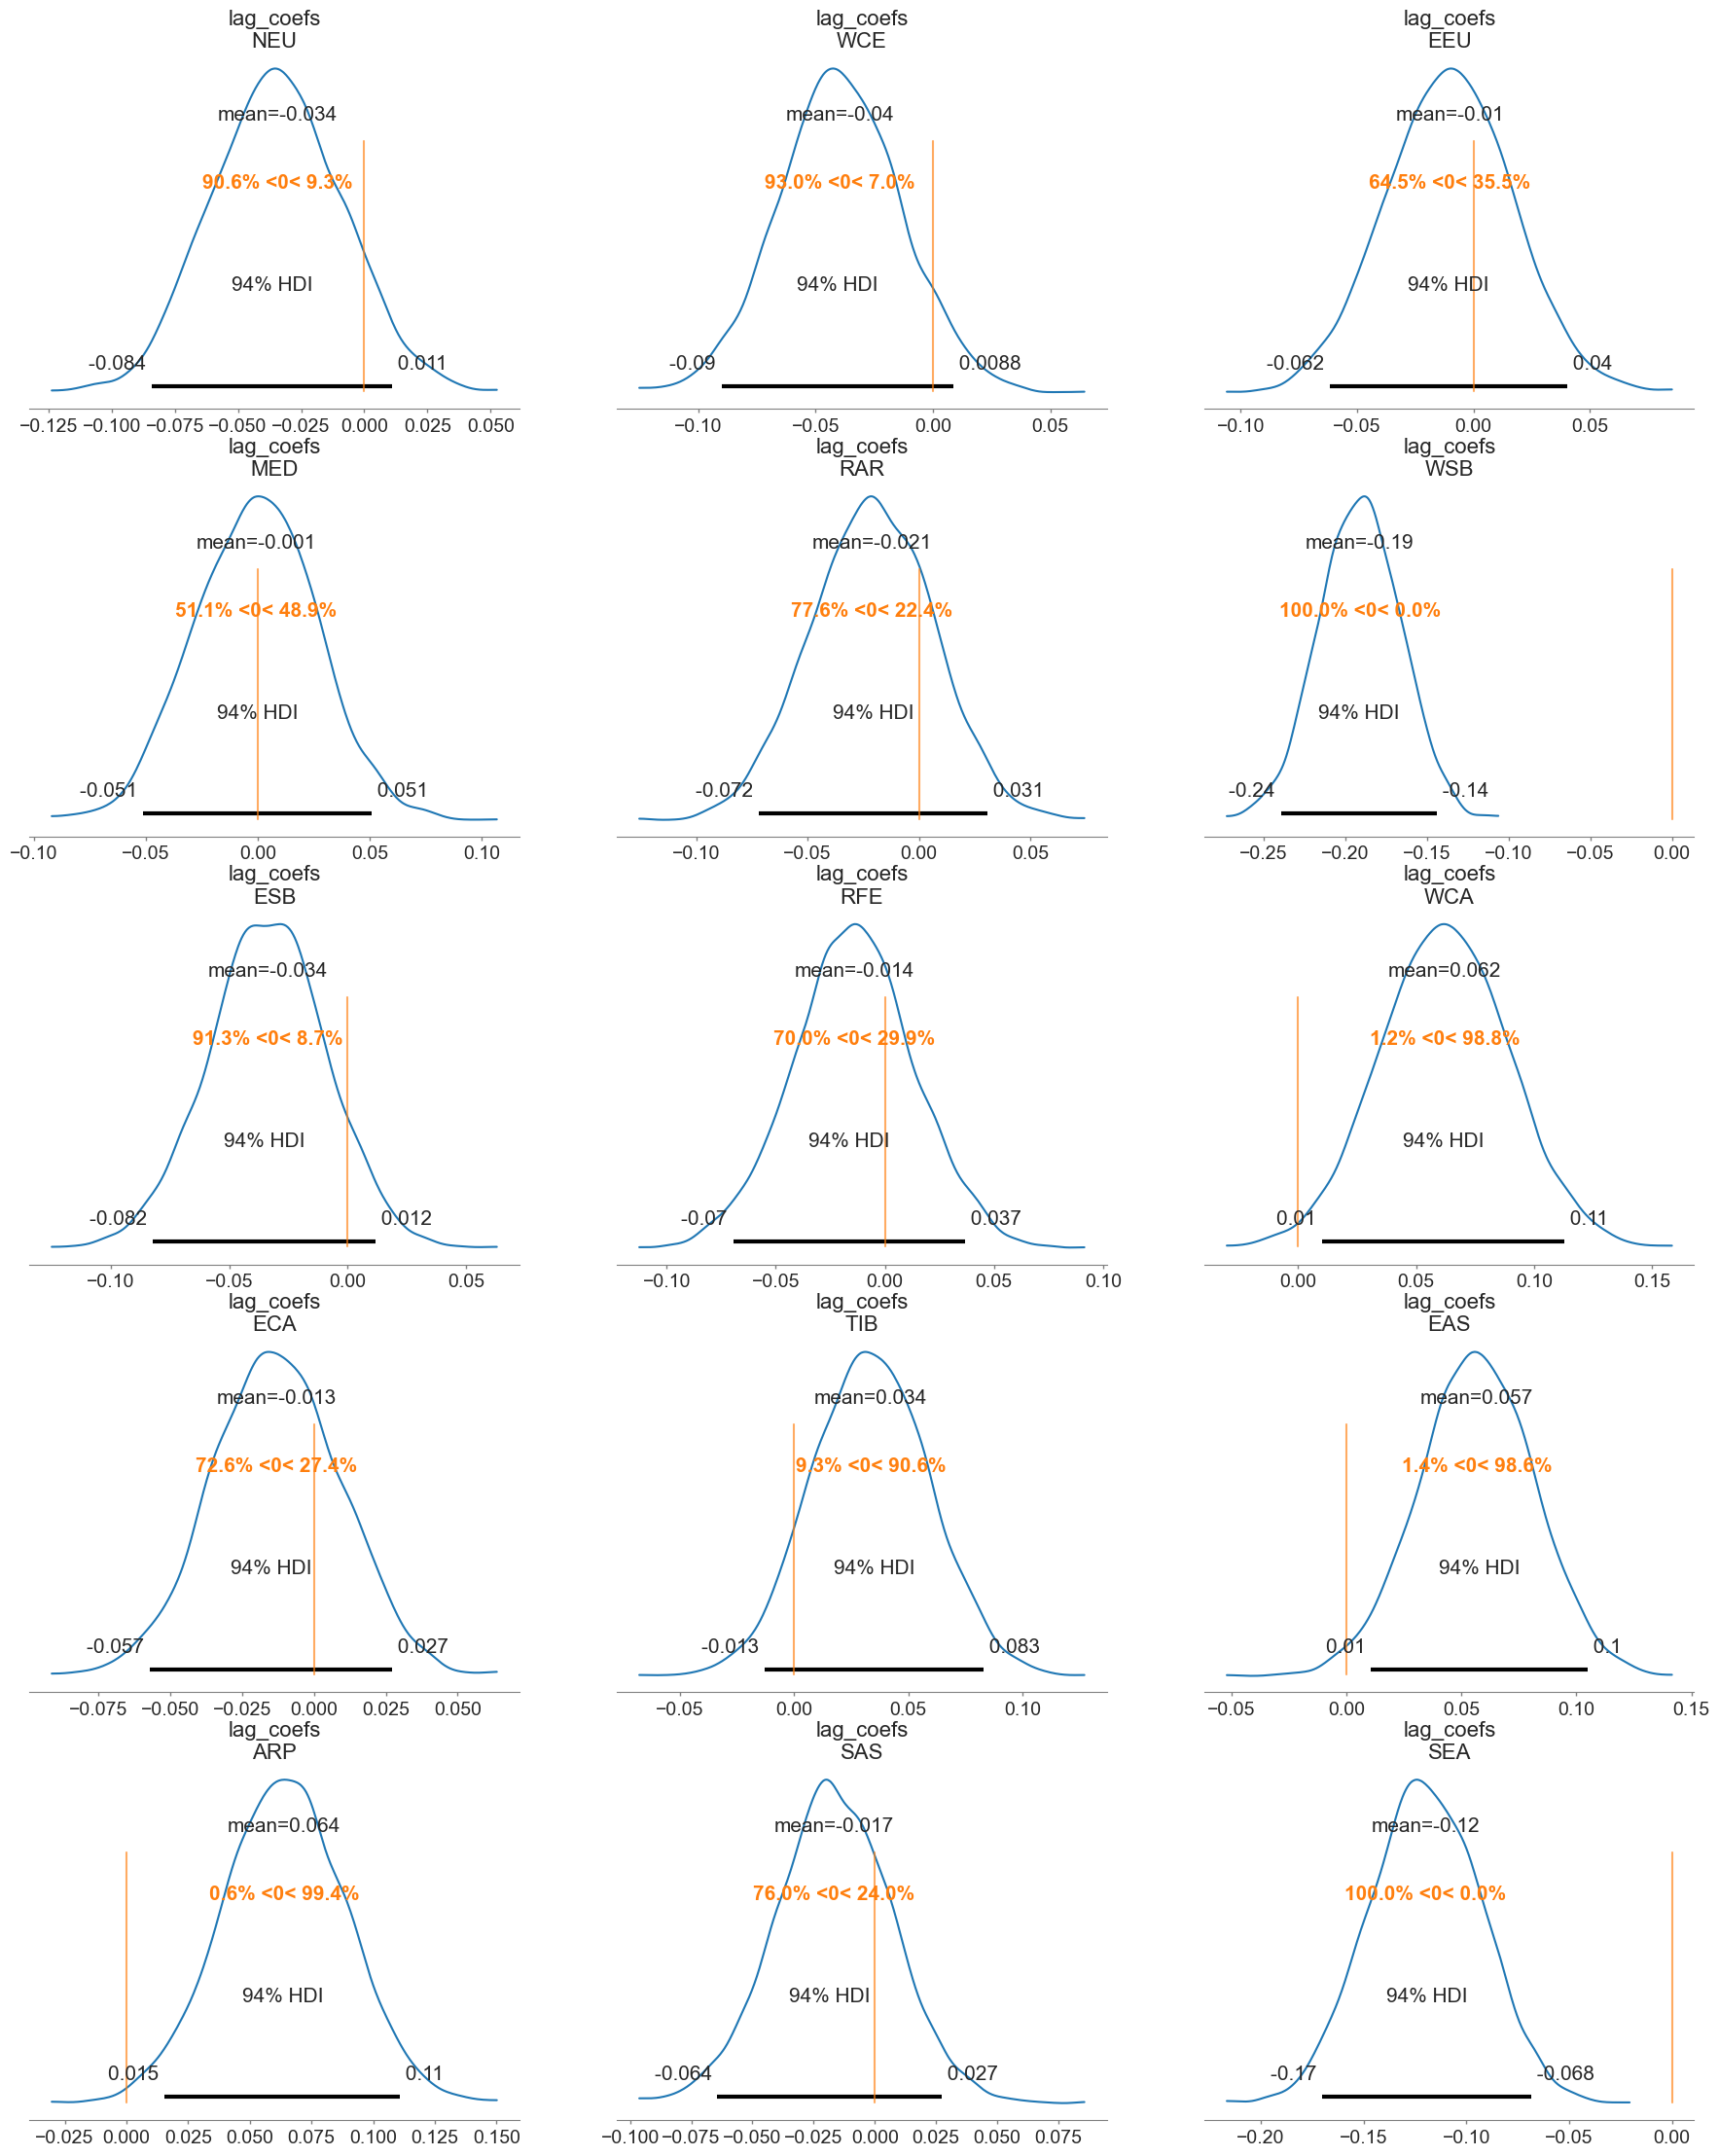

In [509]:
tmp=az.plot_posterior(global_T_trace.posterior.lag_coefs.sel(lags=-2),ref_val=0.)

In [429]:
#split violin


In [407]:
RLAGS1=[]
RLAGS2=[]
RCOV=[]
for region in geda_regions:
    RCOV += [nocross_F_trace.posterior.cov.sel(region=region,cross_region=region).mean(dim=("chain","draw")).values]
    RLAGS1 += [nocross_F_trace.posterior.lag_coefs.sel(region=region,lags=-1).mean(dim=("chain","draw")).values]
    RLAGS2 += [nocross_F_trace.posterior.lag_coefs.sel(region=region,lags=-2).mean(dim=("chain","draw")).values]

In [417]:
geda_regions[np.argsort(RLAGS1)]

array(['WCA', 'EEU', 'ARP', 'MED', 'ECA', 'TIB', 'SEA', 'EAS', 'SAS',
       'NEU', 'RFE', 'WCE', 'RAR', 'ESB', 'WSB'], dtype='<U3')

In [ ]:
# The learned covariance matrix reasonably captures the EOFs!  Only we don't need to reduce the dimensions, we can keep all of it

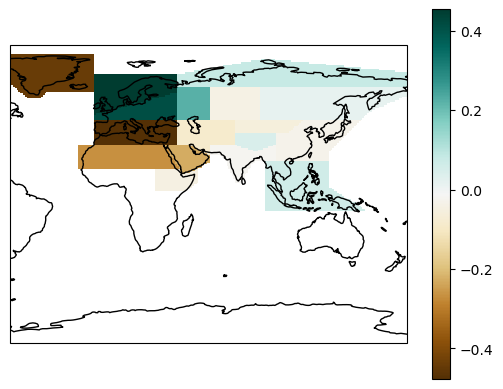

In [126]:
eof1=eigenvectors[:,0]
plot_GEDA(xr.DataArray(data=-eof1,dims=["region"],coords={"region":np.array(coords["region"])}))

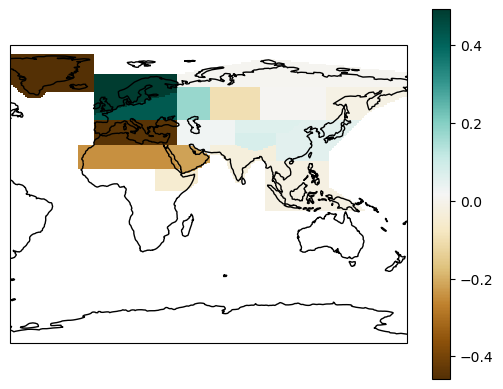

In [119]:
solver=Eof(preindustrial)
plot_GEDA(solver.eofs().sel(mode=0))

In [516]:
with global_T_model:
    g=pm.model_to_graphviz()
    g.render("../Writeup/FIGS/ModelGraph.png")

In [512]:
with noforcing_model:
    g=pm.model_to_graphviz()
    g
    #g.render("../Writeup/FIGS/ModelGraph.png")

In [523]:
g=pm.model_to_graphviz(global_T_model)
g.render("../Writeup/FIGS/ModelGraph.pdf")

'../Writeup/FIGS/ModelGraph.pdf.pdf'

In [531]:

g2=pm.model_to_graphviz(noforcing_model)
g2.render("../Writeup/FIGS/ModelGraph_noforcing")

'../Writeup/FIGS/ModelGraph_noforcing.pdf'